Databricks notebook source
MAGIC %pip install xgboost lightgbm

COMMAND ----------

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import sys
import sklearn
import json

In [2]:
sys.path.append("/app")

from spark_config import get_local_spark

spark = get_local_spark()

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c6fd43c6-2c69-4466-83e3-1bead5d9b998;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.1.0 in central
	found io.delta#delta-storage;3.1.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
downloading https://repo1.maven.org/maven2/io/delta/delta-spark_2.12/3.1.0/delta-spark_2.12-3.1.0.jar ...
	[SUCCESSFUL ] io.delta#delta-spark_2.12;3.1.0!delta-spark_2.12.jar (679ms)
downloading https://repo1.maven.org/maven2/io/delta/delta-storage/3.1.0/delta-storage-3.1.0.jar ...
	[SUCCESSFUL ] io.delta#delta-storage;3.1.0!delta-storage.jar (134ms)
downloading https://repo1.maven.org/maven2/org/antlr/antlr4-runtime/4.9.3/antlr4-runtime-4.9.3.jar ...
	[SUCCESSFUL ] org.antlr#antlr4-runtime;4.9.3!antlr4-runtime.jar (155ms)
:: resolution report :: resolve 3525ms :: artifacts dl 

✅ Spark Session Created
   Spark UI: http://dccad100b71e:4040



COMMAND ----------

In [9]:
# Paths
silver_table = "/app/data/silver/silver_creditcard"
spark = get_local_spark()

✅ Spark Session Created
   Spark UI: http://dccad100b71e:4040



In [10]:
df_silver = spark.read.format("delta").load(silver_table)

COMMAND ----------

In [11]:
df_full = df_silver.toPandas()

COMMAND ----------

In [13]:
df_full.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,ingestion_timestamp,create_silver_timestamp
0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2025-11-12 03:14:58.368688,2025-11-12 03:15:16.545720
1,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,2025-11-12 03:14:58.368688,2025-11-12 03:15:16.545720
2,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,2025-11-12 03:14:58.368688,2025-11-12 03:15:16.545720
3,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,2025-11-12 03:14:58.368688,2025-11-12 03:15:16.545720
4,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0,2025-11-12 03:14:58.368688,2025-11-12 03:15:16.545720


COMMAND ----------

In [14]:
df_full.drop(['create_silver_timestamp','ingestion_timestamp'], axis=1, inplace=True)

COMMAND ----------

In [15]:
df_full.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
2,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
3,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
4,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0


COMMAND ----------

In [16]:
X_full = df_full.drop('Class',axis=1)
y_full = df_full['Class']

COMMAND ----------

In [17]:
X_train_full, X_test_holder, y_train_full, y_test_holder = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

COMMAND ----------

In [18]:
X_train_full.shape

(226980, 30)

COMMAND ----------

In [19]:
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_full, y_train_full, test_size=0.9, stratify=y_train_full, random_state=42)

COMMAND ----------

In [20]:
X_train_sample.shape

(22698, 30)

COMMAND ----------

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

COMMAND ----------

In [22]:
preprocessor = ColumnTransformer(transformers=[('robust', RobustScaler(), ['Amount'])], remainder='passthrough')

COMMAND ----------

In [23]:
scoring = {
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1': make_scorer(f1_score, pos_label=1, zero_division=0)
}

COMMAND ----------

In [30]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight= (len(y_train_sample) - y_train_sample.sum()) / y_train_sample.sum(), random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
}

COMMAND ----------

In [31]:
results = []

In [32]:
for name, model in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    cv_results = cross_validate(pipeline, X_train_sample, y_train_sample, cv=cv, scoring=scoring)
    results.append({
        'model': name,
        'roc_auc': cv_results['test_roc_auc'].mean(),
        'precision': cv_results['test_precision'].mean(),
        'recall': cv_results['test_recall'].mean(),
        'f1': cv_results['test_f1'].mean(),
        'pipe': pipeline
    })

In [33]:
results_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False)
results_df_display = results_df.drop('pipe', axis=1)
print(results_df_display)

                 model   roc_auc  precision    recall        f1
3              XGBoost  0.958398   0.660476  0.707143  0.679048
4             LightGBM  0.956105   0.709286  0.653571  0.677857
0  Logistic Regression  0.947917   0.044201  0.892857  0.084089
2        Random Forest  0.944824   0.800000  0.414286  0.541725
1        Decision Tree  0.745987   0.487937  0.492857  0.486325


COMMAND ----------

In [34]:
top2_models = results_df.head(2)

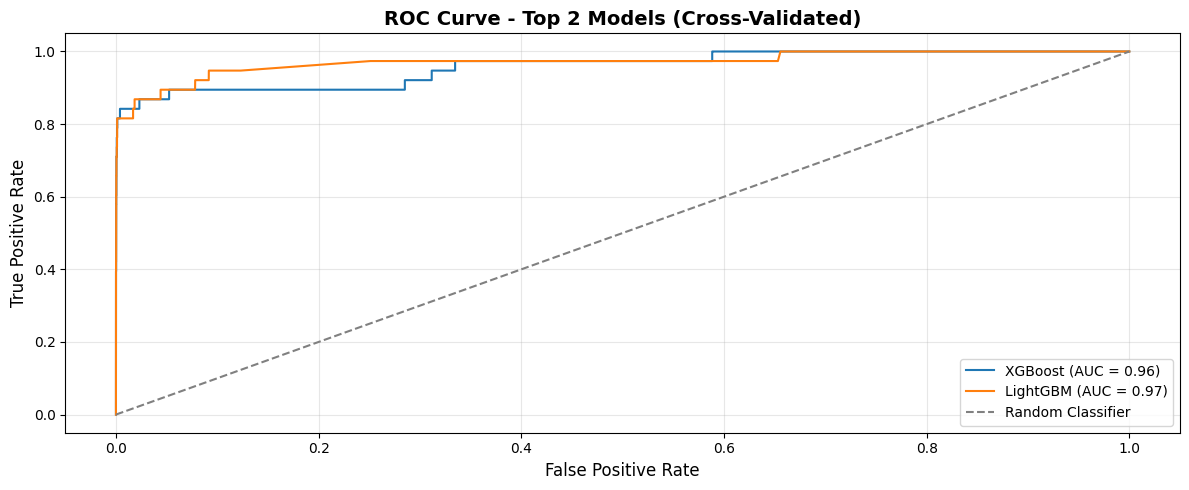

In [36]:
plt.figure(figsize=(12, 5), facecolor='white')
ax = plt.gca()
for idx, row in top2_models.iterrows():
    model_name = row['model']
    pipe = row['pipe']

    y_pred_sample = cross_val_predict(pipe, X_train_sample, y_train_sample, cv=cv, method='predict_proba')[:, 1]
    RocCurveDisplay.from_predictions(y_train_sample, y_pred_sample, name=model_name, ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Top 2 Models (Cross-Validated)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

COMMAND ----------

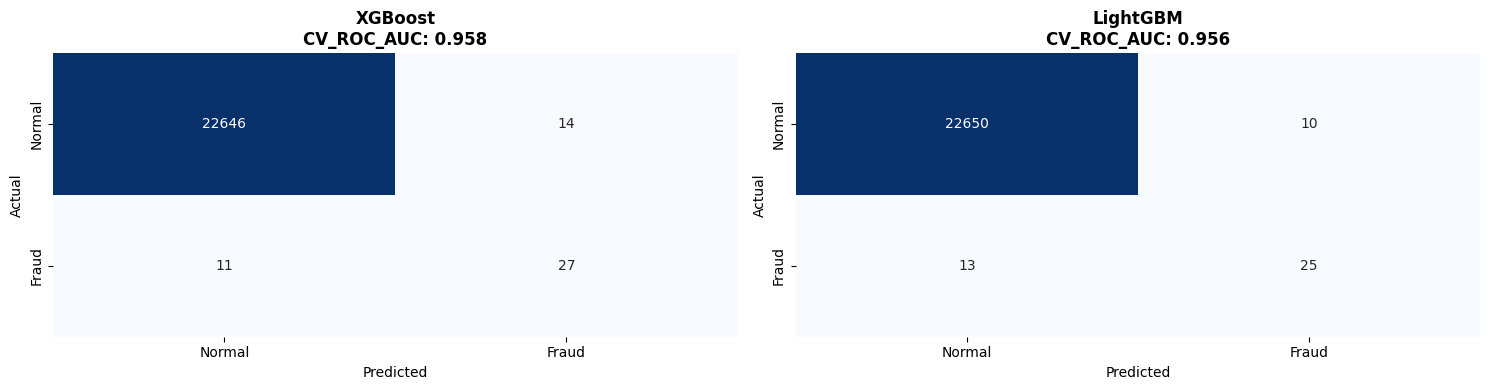

In [37]:
fig, axes = plt.subplots(1,2, figsize=(15, 4))
for ax, (_, row) in zip(axes, top2_models.iterrows()):
    
    model_name = row['model']
    pipe = row['pipe'] 
    
    y_pred_sample = cross_val_predict(pipe, X_train_sample, y_train_sample, cv=cv)
    
    # confusion matrix
    cm = confusion_matrix(y_train_sample, y_pred_sample)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{model_name}\nCV_ROC_AUC: {row["roc_auc"]:.3f}', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Normal', 'Fraud'])
    ax.set_yticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.show()

COMMAND ----------

MAGIC %md
MAGIC hyperparameter tuning

COMMAND ----------

In [38]:
scoring_tune = {
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

COMMAND ----------

In [39]:
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

COMMAND ----------

In [42]:
xgb_pipe = results_df.loc[results_df['model'] == 'XGBoost','pipe'].values[0]
print(xgb_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust', RobustScaler(),
                                                  ['Amount'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature...ow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None,

COMMAND ----------

In [41]:
gric_xgb = GridSearchCV(xgb_pipe, param_grid_xgb, cv=cv, scoring=scoring_tune, refit='roc_auc', verbose=1)
gric_xgb.fit(X_train_sample, y_train_sample)
print(gric_xgb.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}


COMMAND ----------

In [43]:
config = {
    'model': results_df.loc[results_df['model'] == 'XGBoost','model'].values[0],
    'tuned_params': {k.replace('model__', ''): v for k, v in gric_xgb.best_params_.items()},
    'fixed_params': {
        'scale_pos_weight': float((len(y_train_sample) - y_train_sample.sum()) / y_train_sample.sum()),
        'random_state': 42
    },
    'preprocessing': {
        'scaler_type': 'RobustScaler',
        'scaler_name': 'robust',
        'scaled_columns': ['Amount'],
        'passthrough_columns': [c for c in X_train_sample.columns if c != 'Amount']
    },
     'pipeline_steps': [
        {'step': 'preprocessor', 'type': 'ColumnTransformer'},
        {'step': 'model', 'type': results_df.loc[results_df['model'] == 'XGBoost','model'].values[0]}
    ],
    'prototype_performance': {
        'cv_roc_auc': float(results_df.loc[results_df['model'] == 'XGBoost','roc_auc'].values[0]),
        'cv_precision': float(results_df.loc[results_df['model'] == 'XGBoost','precision'].values[0]),
        'cv_recall': float(results_df.loc[results_df['model'] == 'XGBoost','recall'].values[0]),
        'cv_f1': float(results_df.loc[results_df['model'] == 'XGBoost','f1'].values[0]),
        'cv_folds': cv.n_splits,
        'n_samples': len(X_train_sample),
        'fraud_ratio': float(y_train_sample.sum() / len(y_train_sample))
    },
    'feature_columns': list(X_train_sample.columns),
    'target_column': 'Class',
    
    'created_date': datetime.now().isoformat(),
    'created_by': 'prototype_pipeline',
    'sklearn_version': sklearn.__version__,
    'python_version': sys.version.split()[0]
}

COMMAND ----------

In [44]:
print(json.dumps(config, indent=4))

{
    "model": "XGBoost",
    "tuned_params": {
        "colsample_bytree": 0.8,
        "learning_rate": 0.01,
        "max_depth": 7,
        "n_estimators": 200,
        "subsample": 0.8
    },
    "fixed_params": {
        "scale_pos_weight": 596.3157894736842,
        "random_state": 42
    },
    "preprocessing": {
        "scaler_type": "RobustScaler",
        "scaler_name": "robust",
        "scaled_columns": [
            "Amount"
        ],
        "passthrough_columns": [
            "Time",
            "V1",
            "V2",
            "V3",
            "V4",
            "V5",
            "V6",
            "V7",
            "V8",
            "V9",
            "V10",
            "V11",
            "V12",
            "V13",
            "V14",
            "V15",
            "V16",
            "V17",
            "V18",
            "V19",
            "V20",
            "V21",
            "V22",
            "V23",
            "V24",
            "V25",
            "V26",
       

COMMAND ----------

In [45]:
config_path = "../configs/prototype_config.json"  
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)
print("✅ Prototype config saved to configs/prototype_config.json")

✅ Prototype config saved to configs/prototype_config.json
